In [137]:
import os
os.environ['R_HOME'] = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
os.environ["R_SESSION_TMPDIR"] = "/data1/lesliec/sneha/test/"
from rpy2.rinterface_lib import openrlib
openrlib.R_HOME = '/data1/lesliec/sneha/anaconda/envs/crc-env/lib/R'
import scanpy as sc
import pandas
import matplotlib.pyplot as plt
import seaborn
from matplotlib.collections import PathCollection
from scipy import stats
import pickle
import numpy as np

In [21]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [23]:
%%R
library(ArchR)

In [4]:
adata = sc.read_h5ad('./data/multiome_human_scrna.h5ad')

In [5]:
celltype_colors = {'IL10- Treg': '#008856', 'IL10+ Treg': '#DCD300',
                   'PD1+ CD8': '#B3446C', 'CCR7+ T': '#875692', # maybe change this
                   'Cytotoxic gdT': '#848482', 'Cytotoxic CD8': '#2B3D26', 'PD1+ CD4': '#F6A600',
                   'CCR7+ CD4': '#F38400', 'Cytotoxic CD4': '#882D17'}
batch_colors = {'NAT': '#F8766D', 'Tumor': '#00BFC4'}

<Axes: title={'center': 'combat_celltype'}, xlabel='X_combat_umap1', ylabel='X_combat_umap2'>

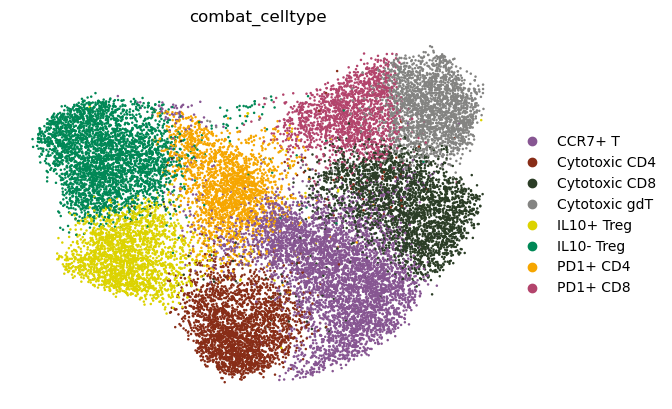

In [6]:
sc.pl.embedding(adata, color='combat_celltype', palette=celltype_colors, basis='X_combat_umap', size=13, show=False,
               frameon=False)

<Axes: title={'center': 'combat_celltype'}, xlabel='X_cellspace_umap1', ylabel='X_cellspace_umap2'>

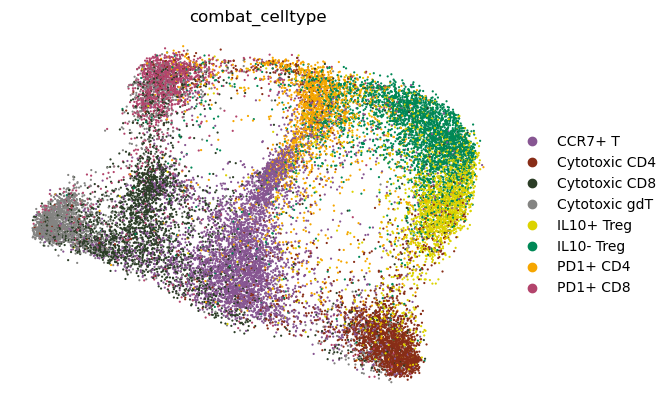

In [7]:
sc.pl.embedding(adata, color='combat_celltype', palette=celltype_colors, basis='X_cellspace_umap', size=10, show=False,
               frameon=False)

<Axes: title={'center': 'tissue'}, xlabel='X_combat_umap1', ylabel='X_combat_umap2'>

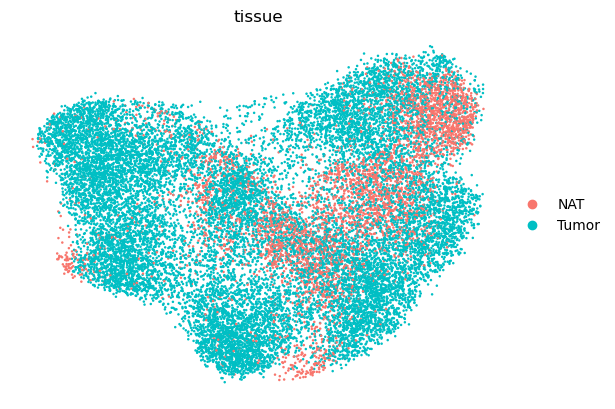

In [8]:
sc.pl.embedding(adata, color='tissue', palette=batch_colors, basis='X_combat_umap', size=13, show=False,
               frameon=False)

<Axes: title={'center': 'tissue'}, xlabel='X_cellspace_umap1', ylabel='X_cellspace_umap2'>

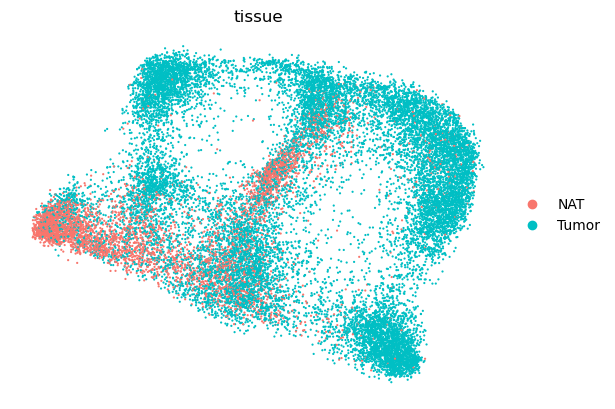

In [9]:
sc.pl.embedding(adata, color='tissue', palette=batch_colors, basis='X_cellspace_umap', size=10, show=False,
               frameon=False)

/tmp/ipykernel_451071/2868330148.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  seaborn.countplot(data=df, y='combat_celltype',


<Axes: xlabel='count', ylabel='combat_celltype'>

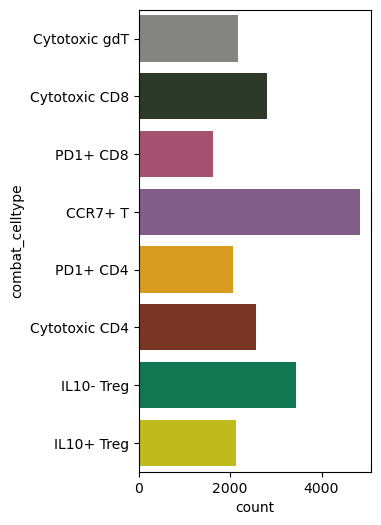

In [14]:
df = adata.obs.copy()
celltype_order = ['IL10+ Treg', 'IL10- Treg', 'Cytotoxic CD4', 'PD1+ CD4', 'CCR7+ T', 'PD1+ CD8', 'Cytotoxic CD8',
                  'Cytotoxic gdT'
                  ]
celltype_order.reverse()

df['combat_celltype'] = pandas.Categorical(df['combat_celltype'].values.tolist(),  
                   categories=celltype_order)
plt.figure(figsize=(3,6))
seaborn.countplot(data=df, y='combat_celltype', 
                  palette=celltype_colors) 

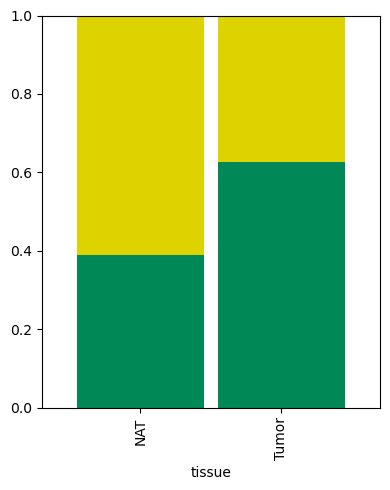

In [17]:
df = adata.obs.copy()
#df = df[df['tissue'] != 'NAT']
df['tissue'] = df['tissue'].values.tolist()
df['combat_celltype'] = df['combat_celltype'].values.tolist()
df = df[df['combat_celltype'].isin(['IL10+ Treg', 'IL10- Treg'])]
celltype_order = ['IL10+ Treg', 'IL10- Treg']
celltype_order.reverse()

df = adata.obs.copy()
#df = df[df['tissue'] != 'NAT']
df['tissue'] = df['tissue'].values.tolist()
df['combat_celltype'] = df['combat_celltype'].values.tolist()
df = df[df['combat_celltype'].isin(['IL10+ Treg', 'IL10- Treg'])]
df = df.groupby(['combat_celltype', 'tissue']).size().reset_index(name='count')
df['combat_celltype'] = pandas.Categorical(df['combat_celltype'].values.tolist(),  
                   categories=celltype_order)
df = df.pivot(index='tissue', columns='combat_celltype', values='count')
df = df.iloc[::-1]
df_sum = df.sum(1).values.copy()
for c in df.columns: df[c] = df[c].values/df_sum
df = df.iloc[::-1]

fig = plt.figure(figsize=(4,5))
df.plot.bar(stacked=True, color=celltype_colors, width=0.9, ax=plt.gca()) # , ax=ax[1])
plt.gca().set_ylabel("")
plt.subplots_adjust(wspace=0, hspace=0)
plt.gca().get_legend().remove()
plt.gca().grid(visible=True, alpha=0.3)
plt.ylim((0, 1))
plt.grid(False)
plt.tight_layout()

In [18]:
celltypes = adata.obs.copy()
celltypes.index = ['human#' + x for x in celltypes.index]

In [ ]:
scatac_file <- "/data1/lesliec/sneha/workspace/CRC_analysis/outfiles/human/scatac"
scatac.object <- loadArchRProject(scatac_file)

In [35]:
%%R -i celltypes
scatac.object <- loadArchRProject("./data/multiome_human_scatac")
scatac.object <- scatac.object[scatac.object$cellNames %in% rownames(celltypes),]
scatac.object <- addCellColData(
  ArchRProj = scatac.object,
  data = as.character(celltypes$combat_celltype),
  name = 'combat_celltype',
  cells = rownames(celltypes),
  force = TRUE
)

Successfully loaded ArchRProject!

                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  ._____

 [1] "AC0242|FOSL/JUND|bZIP"             "AC0255|GATA|GATA"                 
 [3] "AC0014|BATF/FOSL|bZIP"             "AC0196|NFKB/RELA|Rel"             
 [5] "AC0430|TCF7L/LEF|Sox"              "AC0554|HIF1A/TCFL|bHLH"           
 [7] "AC0408|RORC/RORA|Nuclear_receptor" "AC0424|NR4A|Nuclear_receptor"     
 [9] "AC0017|RUNX|Runt"                  "AC0635|TBX/EOMES|T-box"           


Identified 10 markers!
Adding Annotations..
Preparing Main Heatmap..
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.


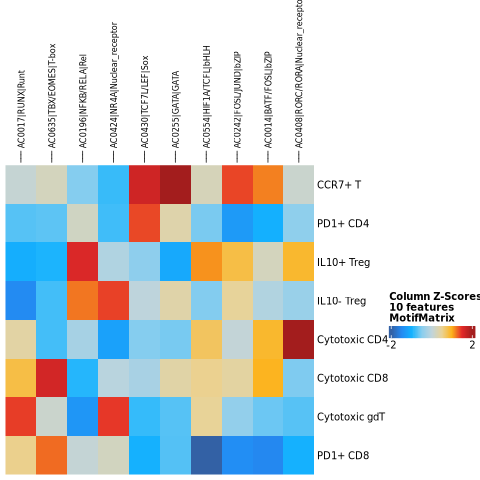

In [112]:
%%R
markersMM <- getMarkerFeatures(
    ArchRProj = scatac.object,
    useMatrix = "MotifMatrix",
    groupBy = "combat_celltype",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    useSeqnames="deviations", # "z"
    testMethod = "wilcoxon")

markersMM_sub <- markersMM[grepl("AC0255", rowData(markersMM)$name) | 
                                 grepl("TCF7", rowData(markersMM)$name) |
                                 grepl("EOMES", rowData(markersMM)$name) | 
                                 grepl("RORC", rowData(markersMM)$name) |
                                 grepl("AC0017", rowData(markersMM)$name) | 
                                 grepl("AC0014", rowData(markersMM)$name) | 
                                 grepl("AC0242", rowData(markersMM)$name) | 
                                 grepl("AC0196", rowData(markersMM)$name) | 
                                 grepl("HIF1A", rowData(markersMM)$name) | 
                                 grepl("AC0424", rowData(markersMM)$name) | 
                                 grepl("TCF7", rowData(markersMM)$name),]

markersMM_sub <- markersMM_sub[, match(c('CCR7+ T', 'PD1+ CD4', 'IL10+ Treg', 'IL10- Treg', 
                                        'Cytotoxic CD4', 'Cytotoxic CD8', 'Cytotoxic gdT', 
                                        'PD1+ CD8'), colnames(markersMM_sub))]

markersMM_sub <- markersMM_sub[match(c('AC0554|HIF1A/TCFL|bHLH', 'AC0242|FOSL/JUND|bZIP',
                                      #'AC0508|FOSL|bZIP', 
                                       'AC0408|RORC/RORA|Nuclear_receptor',
                                      'AC0014|BATF/FOSL|bZIP', 'AC0196|NFKB/RELA|Rel',
                                      'AC0430|TCF7L/LEF|Sox', 'AC0255|GATA|GATA', 
                                      'AC0424|NR4A|Nuclear_receptor', 'AC0017|RUNX|Runt', 
                                      'AC0635|TBX/EOMES|T-box'), rowData(markersMM_sub)$name), ]

heatmapMM <- plotMarkerHeatmap(
  seMarker = markersMM_sub, 
  cutOff = "FDR <= 1e-2", 
  transpose = TRUE,
  log2Norm = FALSE, returnMatrix=FALSE, 
  binaryClusterRows=FALSE, clusterCols=FALSE, limits = c(-2, 2),
)

heatmapMM

In [120]:
from gseapy import Biomart
bm = Biomart()
# note the dataset and attribute names are different
m2h = bm.query(dataset='mmusculus_gene_ensembl',
               attributes=['ensembl_gene_id','external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

m2h_d = {}
for i,r in m2h.iterrows():
    if r['hsapiens_homolog_associated_gene_name'] is None: continue
    m2h_d[r['external_gene_name']] = r['hsapiens_homolog_associated_gene_name']

In [123]:
hotspot_mouse_genes_1 = ['Ikzf2', 'Il1rl1', 'Gata3', 'Rel', 'Tox', 'Flnb', 'Tnfrsf9', 'Nfkb1',
       'Tent5a', 'Tmtc2', 'Epas1', 'Rora', 'Il18rap', 'Klrg1', 'Cd83', 'Mgat5',
       'Dgat2', 'Swap70', 'Myo1e', 'Ikzf4', 'Tspan13', 'Dusp10', 'Pdcd1',
       'Gm28112', 'Stat4', 'Pcgf5']

hotspot_mouse_genes_2 = ['Pkp4', 'Zbtb46', 'Ly75', 'Itgb8', 'Ttn', 'Pcyt1a', 'Gda', 'Il2ra',
       'Uap1', 'Zc3h12c', 'Il18r1', 'Epb41l2', 'Traf3', 'Cep85l', 'Rbpj',
       'Stat1', 'Itgav', 'Ankrd33b', 'Bcl2l1', 'Fam129a', 'Ttc39c', 'Ap3b1',
       'Ppp1r16b', 'Myo10', 'Apaf1', 'Itga4', 'Rnf157', 'Nrip1']
hotspot_mouse_genes_Il10 = ['Il10', 'Maf', 'Ctla4', 'Ccr2', 'Nckap5', 'Ece1', 'Zeb2', 'Itm2b',
       'Ikzf3', 'Rabgap1l', 'Icos', 'Havcr2', 'Gzmb', 'Lag3', 'Gm36975', 'Neb',
       'Gas2', 'Cytip', 'Galnt2', 'Ccr5', 'Il1r1', 'Pde4b', 'Gcnt2', 'Olfr60',
       'Lrrfip2', '4930503L19Rik', 'E130308A19Rik', 'Gm13481', 'Ccr1',
       'Atp10a', 'Snx9', 'Gm49890', 'Agfg1', 'Ppp1r14c', 'Tiparp', 'Il23r',
       'Matn2', 'Rgs1', 'Fmnl2', 'Phactr2', 'Farp1', 'Irak3', 'Eea1',
       'Ubash3b', 'St6galnac3', 'Lamc1', 'Got1', 'Smap2', 'Wdfy2', 'Rbm24',
       'Ston2', 'Adam12', 'Twsg1', 'Hnrnpll', 'Ets2', 'Timp2', 'Dock10',
       'Ier5l', 'Arl4c']

hotspot_mouse_genes_1 = [m2h_d[x] if x in m2h_d else None for x in hotspot_mouse_genes_1]
hotspot_mouse_genes_2 = [m2h_d[x] if x in m2h_d else None for x in hotspot_mouse_genes_2]
hotspot_mouse_genes = hotspot_mouse_genes_1 + hotspot_mouse_genes_2
hotspot_mouse_genes_Il10 = [m2h_d[x] if x in m2h_d else None for x in hotspot_mouse_genes_Il10]

In [124]:
def calc_significance(adata, celltype_col, score_name, celltype1, celltype2):
    s1 = adata.obs[adata.obs[celltype_col]==celltype1][score_name].values
    s2 = adata.obs[adata.obs[celltype_col]==celltype2][score_name].values
    print(score_name, celltype1, celltype2)
    print(stats.mannwhitneyu(s1, s2))

In [125]:
adata_tmp = adata[adata.obs['combat_celltype'].isin(['IL10+ Treg', 'IL10- Treg', 'PD1+ CD4'])].copy()
sc.pp.filter_genes(adata_tmp, min_cells=50)
sc.tl.score_genes(adata_tmp, gene_list=adata_tmp.var_names[adata_tmp.var_names.isin(hotspot_mouse_genes)], 
                  score_name='mouse_module_il10_neg')
sc.tl.score_genes(adata_tmp, gene_list=adata_tmp.var_names[adata_tmp.var_names.isin(hotspot_mouse_genes_Il10)], 
                  score_name='mouse_module_il10_pos')

mouse_module_il10_neg IL10+ Treg IL10- Treg
MannwhitneyuResult(statistic=np.float64(3179508.0), pvalue=np.float64(7.686527876307638e-17))
mouse_module_il10_neg IL10+ Treg PD1+ CD4
MannwhitneyuResult(statistic=np.float64(2994320.0), pvalue=np.float64(7.938588452593655e-88))
mouse_module_il10_neg IL10- Treg PD1+ CD4
MannwhitneyuResult(statistic=np.float64(5191431.0), pvalue=np.float64(8.541831295305362e-180))
mouse_module_il10_pos IL10+ Treg IL10- Treg
MannwhitneyuResult(statistic=np.float64(5245332.0), pvalue=np.float64(1.859168538780527e-161))
mouse_module_il10_pos IL10+ Treg PD1+ CD4
MannwhitneyuResult(statistic=np.float64(3363809.0), pvalue=np.float64(4.800390082373898e-188))
mouse_module_il10_pos IL10- Treg PD1+ CD4
MannwhitneyuResult(statistic=np.float64(3908995.0), pvalue=np.float64(7.798086162081024e-10))


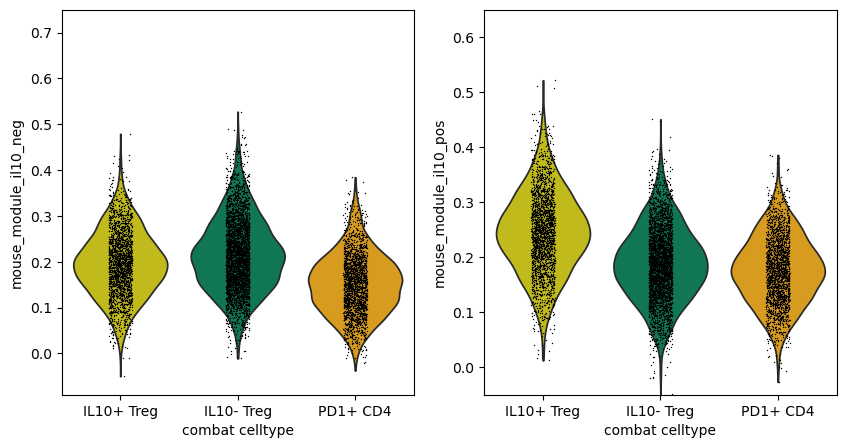

In [129]:
fig,ax = plt.subplots(1, 2, figsize=(10,5))

sc.pl.violin(adata_tmp, 'mouse_module_il10_neg', groupby='combat_celltype', ax=ax[0], show=False)
sc.pl.violin(adata_tmp, 'mouse_module_il10_pos', groupby='combat_celltype', ax=ax[1], show=False)
calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_neg', 'IL10+ Treg', 'IL10- Treg')
calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_neg', 'IL10+ Treg', 'PD1+ CD4')
calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_neg', 'IL10- Treg', 'PD1+ CD4')

calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_pos', 'IL10+ Treg', 'IL10- Treg')
calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_pos', 'IL10+ Treg', 'PD1+ CD4')
calc_significance(adata_tmp, 'combat_celltype', 'mouse_module_il10_pos', 'IL10- Treg', 'PD1+ CD4')
ax[0].set_ylim((-0.09, 0.75))
ax[1].set_ylim((-0.05, 0.65))
for artist in ax[0].findobj(PathCollection):  # takes only the dots from the overlayed stripplot in this example
    artist.set_rasterized(True)
for artist in ax[1].findobj(PathCollection):  # takes only the dots from the overlayed stripplot in this example
    artist.set_rasterized(True)

In [132]:
# milo modules
modules_df = pandas.read_csv("./data/hotspot_human_modules.csv", sep="\t", index_col=0)
modules = {}
for i in range(1, modules_df['Module'].unique().shape[0]):
    if i == 1: name = 'NR4A1'
    elif i == 2: name = 'ZEB2,MAF,PPARG,CCR4,KLRB1'
    elif i == 3: name = 'IL2RA,CCR6,CD44,STAT4'
    elif i == 4: name = 'IKZF2,CADM1,TNFRSF9,GATA3,IL1RL1,ZEB1,BATF,CCR8'
    elif i == 5: name = 'LEF1,TIGIT,SELL'
    modules[name] = modules_df[modules_df['Module']==i].index.tolist()

module_sorted = {}
module_sorted['IKZF2,CADM1,TNFRSF9,GATA3,IL1RL1,ZEB1,BATF,CCR8'] = modules['IKZF2,CADM1,TNFRSF9,GATA3,IL1RL1,ZEB1,BATF,CCR8']
module_sorted['LEF1,TIGIT,SELL'] = modules['LEF1,TIGIT,SELL']
module_sorted['IL2RA,CCR6,CD44,STAT4'] = modules['IL2RA,CCR6,CD44,STAT4']
module_sorted['ZEB2,MAF,PPARG,CCR4,KLRB1'] = modules['ZEB2,MAF,PPARG,CCR4,KLRB1']
module_sorted['NR4A1'] = modules['NR4A1']

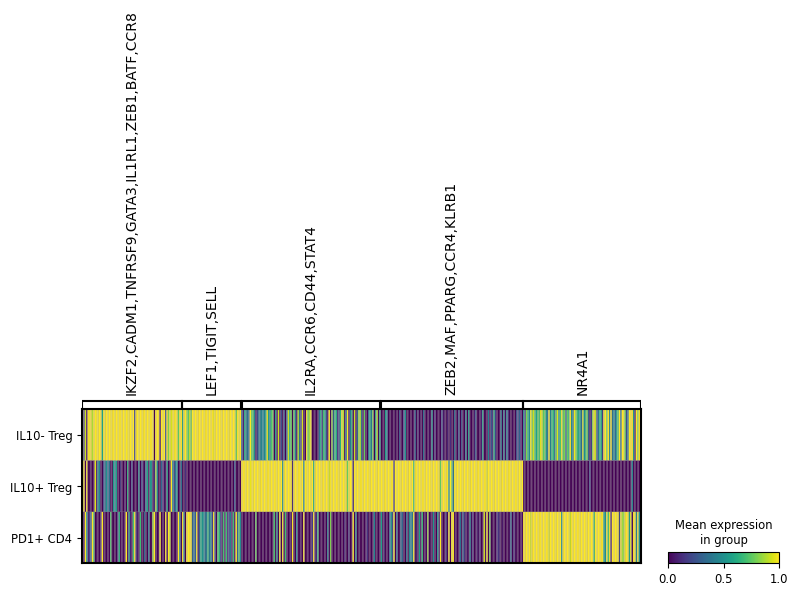

In [133]:
a = sc.pl.matrixplot(adata[adata.obs['combat_celltype'].isin(['IL10- Treg', 'IL10+ Treg', 'PD1+ CD4'])], #, 'PD1+ CD4'])],
             module_sorted, figsize=(9, 2),
             groupby='combat_celltype', standard_scale='var', use_raw=True, show=False, #show_gene_labels=False
            categories_order=['IL10- Treg', 'IL10+ Treg', 'PD1+ CD4']
        ) #, dendrogram=False, 
a['mainplot_ax'].set_xticks([])
a['mainplot_ax'].set_rasterized(True)

In [135]:
adata_p1 = pickle.load(open("./data/visium_p1_008_tacco.pkl", 'rb'))
adata_p3 = pickle.load(open("./data/visium_p3_008_tacco.pkl", 'rb'))

In [138]:
vmax_il10_neg = np.percentile(adata_p1.obs[["IL10- Treg"]].values.tolist() + adata_p3.obs[["IL10- Treg"]].values.tolist(), 99.99)
vmax_il10_pos = np.percentile(adata_p1.obs[["IL10+ Treg"]].values.tolist() + adata_p3.obs[["IL10+ Treg"]].values.tolist(), 99.99)
vmax_il10_neg, vmax_il10_pos

(np.float64(0.45165203633418005), np.float64(0.16463696210584136))

[<Axes: title={'center': 'IL10- Treg'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'IL10+ Treg'}, xlabel='spatial1', ylabel='spatial2'>]

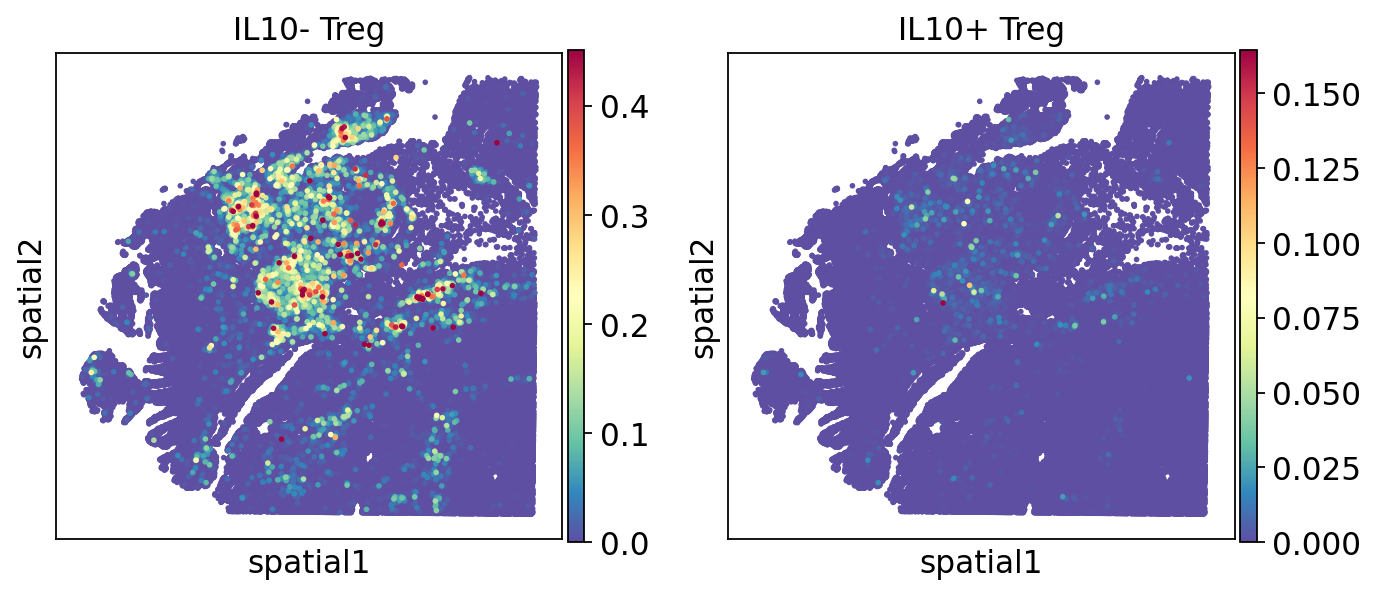

In [139]:
sc.set_figure_params(vector_friendly=True)
sc.pl.spatial(adata_p1, color=["IL10- Treg", "IL10+ Treg"], size=10, alpha_img=0.5, 
              vmax=[vmax_il10_neg, vmax_il10_pos],
             cmap='Spectral_r', show=False, img_key=None) # "hires") # inferno

[<Axes: title={'center': 'IL10- Treg'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'IL10+ Treg'}, xlabel='spatial1', ylabel='spatial2'>]

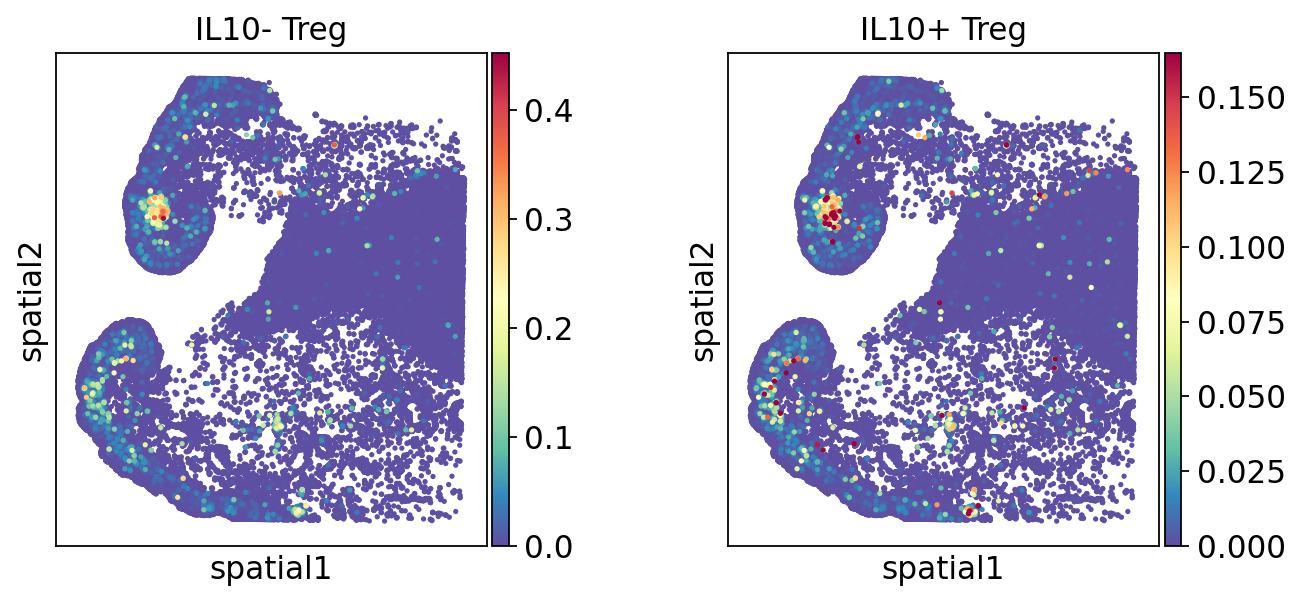

In [140]:
sc.set_figure_params(vector_friendly=True)
sc.pl.spatial(adata_p3, color=["IL10- Treg", "IL10+ Treg"], size=10, alpha_img=0.5, 
              vmax=[vmax_il10_neg, vmax_il10_pos],
             cmap='Spectral_r', show=False, img_key=None) # "hires")